<p style="border: 1px solid #e7692c; border-left: 15px solid #e7692c; padding: 10px; text-align:justify;">
    <strong style="color: #e7692c">Tip.</strong> <a style="color: #000000;" href="https://nbviewer.jupyter.org/github/PacktPublishing/Hands-On-Computer-Vision-with-TensorFlow-2/blob/master/Chapter07/ch7_nb5_train_a_simple_domain_adversarial_network_(dann).ipynb" title="View with Jupyter Online">Click here to view this notebook on <code>nbviewer.jupyter.org</code></a>. 
    <br/>These notebooks are better read there, as Github default viewer ignores some of the formatting and interactive content.
    </p>

<table style="font-size: 1em; padding: 0; margin: 0;">
    <tr style="vertical-align: top; padding: 0; margin: 0;background-color: #ffffff">
        <td style="vertical-align: top; padding: 0; margin: 0; padding-right: 15px;">
    <p style="background: #363636; color:#ffffff; text-align:justify; padding: 10px 25px;">
        <strong style="font-size: 1.0em;"><span style="font-size: 1.2em;"><span style="color: #e7692c;">Hands-on</span> Computer Vision with TensorFlow 2</span><br/>by <em>Eliot Andres</em> & <em>Benjamin Planche</em> (Packt Pub.)</strong><br/><br/>
        <strong>> Chapter 7: Training on Complex and Scarce Datasets</strong><br/>
    </p>

<h1 style="width: 100%; text-align: left; padding: 0px 25px;"><small style="color: #e7692c;">
    Notebook 5:</small><br/>Training a Domain Adversarial Neural Network (DANN)</h1>
<br/>
<p style="border-left: 15px solid #363636; text-align:justify; padding: 0 10px;">
    In the previous Notebook <a href="./ch7_nb4_train_segmentation_model_on_synthetic_images.ipynb">7-4</a>, we demonstrated how the <em><strong>realism gap</strong></em> can affect recognition models trained on synthetic data.<br/><br/>
    We detailed a variety of approaches to this problem in Chapter 7, presenting several <strong><em>domain adaptation</em></strong> methods. Their purpose is to edit models and/or guide their training so that even though they were optimize for data from one <em>source domain</em> (e.g., synthetic image domain), they can perform on another <em>target domain</em> (e.g., real images). In this notebook, we will introduce and implement a domain adaptation method which has  been receiving lots of praise: <em><strong>DANN</strong></em>.
</p>
<br/>
<p style="border-left: 15px solid #e7692c; padding: 0 10px; text-align:justify;">
    <strong style="color: #e7692c;">Tip.</strong> The notebooks shared on this git repository illustrate some notions from the book "<em><strong>Hands-on Computer Vision with TensorFlow 2</strong></em>" written by Eliot Andres and Benjamin Planche, published by Packt. If you enjoyed the insights shared here, <a href="https://www.amazon.com/Hands-Computer-Vision-TensorFlow-processing/dp/1788830644" title="Learn more about the book!"><strong>please consider acquiring the book!</strong></a>
<br/><br/>
The book provides further guidance for those eager to learn about computer vision and to harness the power of TensorFlow 2 and Keras to build efficient recognition systems for object detection, segmentation, video processing, smartphone applications, and more.</p>
        </td>
        <td style="vertical-align: top; padding: 0; margin: 0; width: 280px;">
    <a href="https://www.amazon.com/Hands-Computer-Vision-TensorFlow-processing/dp/1788830644" title="Learn more about the book!" target="_blank">
        <img src="../banner_images/book_cover.png" width=280>
    </a>
    <p style="background: #e7692c; color:#ffffff; padding: 10px; text-align:justify;"><strong>Leverage deep learning to create powerful image processing apps with TensorFlow 2 and Keras. <br/></strong>Get the book for more insights!</p>
    <ul style="height: 32px; white-space: nowrap; text-align: center; margin: 0px; padding: 0px; padding-top: 10px;">
    <li style="display: block;height: 100%;float: left;vertical-align: middle;margin: 0 25px 10px;padding: 0px;">
        <a href="https://www.amazon.com/Hands-Computer-Vision-TensorFlow-processing/dp/1788830644" title="Get the book on Amazon (paperback or Kindle version)!" target="_blank">
        <img style="vertical-align: middle; max-width: 72px; max-height: 32px;" src="../banner_images/logo_amazon.png" width="75px">
        </a>
    </li>
    <li style="display: inline-block;height: 100%;vertical-align: middle;float: right;margin: -5px 25px 10px;padding: 0px;">
        <a href="https://www.packtpub.com/application-development/hands-computer-vision-tensorflow-2" title="Get your Packt book (paperback, PDF, ePUB, or MOBI version)!" target="_blank">
        <img style="vertical-align: middle; max-width: 72px; max-height: 32px;" src="../banner_images/logo_packt.png" width="75px">
        </a>
    </li>
    </ul>
        </td>
        </tr>
        </table>

In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

random_seed = 42
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

### Introducing Domain Adaptation Scenarios

To illustrate the kind of scenarios domain adaptations are dealing with, we will set up a toy experiment: the ***binary classification of 3D points***.

***Note:*** This toy experiment is inspired by the one used by [Clayton Mellina](https://github.com/pumpikano) to demonstrate *DANN* in a [notebook](https://github.com/pumpikano/tf-dann/blob/master/Blobs-DANN.ipynb) he shared. 

Let us imagine that instead of dealing with images composed of $h \times w \times c$ values, we have for inputs tensors composed of $3$ values, i.e., 3D points. Let us also imagine that the dataset of 3D points we are considering is composed of 2 classes, and we want to train a model to efficiently perform classification.

In [2]:
num_classes = 2
input_size  = (3,)
num_epochs  = 100
batch_size  = 100

We will generate ourself the data we want to play with. We will create two _blobs_ of 3D points, each representing one of the classes:

In [3]:
def create_sample_blobs(blob_centers, blob_stds, blob_num_samples, shuffle=True):
    """
    Create X blobs of N_x elements of shape (D_0, ..., D_d), picked from different 
    normal distributions N(m_x, s_x).
    Note: this is a simplified version of the method `sklearn.datasets.make_blobs`
    :param blob_centers:     Array of shape (X, D_0, ..., D_d) defining the distribution means m_x
    :param blob_stds:        Array of shape (X, D_0, ..., D_d) defining the distribution STDs s_x
    :param blob_num_samples: Array of shape (X,) defining the numbers N_x of elements per blob
    :param shuffle:          Flag to shuffle the elements from all blobs
    :return:                 x: Samples array of shape (N_0 + ... + N_x, D_0, ..., D_d) 
                             y: Class array of shape (N_0 + ... + N_x,) 
    """
    num_blobs = len(blob_centers)
    input_size = len(blob_centers[0])
    x, y = [], []
    for i in range(num_blobs):
        x_i = np.random.normal(loc=blob_centers[i], scale=blob_stds[i], 
                               size=(blob_num_samples[i], input_size))
        y_i = [i] * blob_num_samples[i]
        
        x.append(x_i)
        y += y_i
    x = np.concatenate(x, axis=0)
    y = np.asarray(y)
    if shuffle:
        shuffled_indices = np.random.permutation(len(y))
        x, y = x[shuffled_indices], y[shuffled_indices]
    return x, y

We create two blobs representing our two classes:

In [4]:
num_source_samples_per_class = 500
num_source_samples = num_source_samples_per_class * num_classes

x_source, y_source = create_sample_blobs(
    blob_centers=[[0, 0, 0],  # center of blob for class 0
                  [2, 4, 4]], # center of blob for class 1
    blob_stds=[[.5, .5, .5],  # STD of blob for class 0
               [.5, .5, .5]], # STD of blob for class 01
    blob_num_samples=[num_source_samples_per_class] * num_classes)

Let us have a look:

/home/benjamin/anaconda3/envs/tf2/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


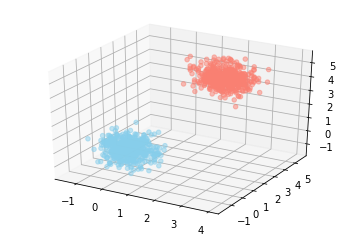

In [5]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x_source[..., 0], x_source[..., 1], x_source[..., 2], 
           c=[["skyblue", "salmon"][class_id] for class_id in y_source], 
           marker='o', s=20, alpha=.5)
fig.show()

The blue points belong to class #0, the red points to class #1. The toy problem we create seems, therefore, quite simple. Even a linear classifier could discriminate these two classes.

But here is the thing: let us say the data we just generated is our **training dataset**, i.e., the labelled samples we manage to gather to train our classifier. And the problem is, the samples we gathered may not be representative of the actual distribution of the whole population of 3D points we want to apply our classifier to. For example, our dataset could be somehow *biased* (e.g., we captured images only during daytime but want to train a visual recognition method also performing with night-time images). Maybe we did not manage to gather any real data and had to render *synthetic* samples using a not-realistic-enough simulator...

### Preparing Source and Target Data

So, back to our toy experiment, let us create blobs representing the *real* data we want our classifier to perform on, assuming we **do not have access to these samples at training time***.

To follow domain adaptation formalism, we will call ***source domain*** the distribution of labelled data we have access to, and ***target domain*** the distribution we want our model to be performant over, but which we don't really know at training time.

In [6]:
num_target_samples_per_class = 200
num_target_samples = num_target_samples_per_class * num_classes

x_target, y_target = create_sample_blobs(
    blob_centers=[[6, 3, 3], [7, 6, 7]], 
    blob_stds=[[1, 1, 1], [1, 1, 1]], 
    blob_num_samples= [num_target_samples_per_class] * num_classes)

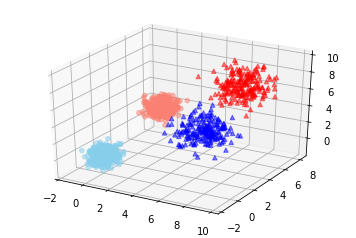

In [7]:
def plot_3d_source_and_target_blobs(x_s, y_s, x_t, y_t=None):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(x_s[..., 0], x_s[..., 1], x_s[..., 2], 
               c=[["skyblue", "salmon"][class_id] for class_id in y_s], 
               marker='o', s=20, alpha=.5)
    ax.scatter(x_t[..., 0], x_t[..., 1], x_t[..., 2],
               c=[["b", "r"][class_id] for class_id in y_t] if y_t is not None else "grey", 
               marker='^', s=20, alpha=.5)
    fig.show()
    
plot_3d_source_and_target_blobs(x_source, y_source, x_target, y_target)

We plotted with darker colors and triangular markers the two sets of target data. This new samples will be our test data.

### Training on Source Data Only

Time to create our model, a simple fully-connected classifier:

In [8]:
from tensorflow.keras.layers import Input, Dense, Activation, Dropout
from tensorflow.keras.models import Model

# Name of the final layer of our simple classifier:
class_preds_head_name = 'class_preds' 

inputs        = Input(shape=input_size) 
hidden1       = Dense(5, activation='relu')(inputs)
class_preds = Dense(num_classes, activation='softmax', name=class_preds_head_name)(hidden1)  

classification_model = Model(inputs=inputs, outputs=class_preds)
classification_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3)]               0         
_________________________________________________________________
dense (Dense)                (None, 5)                 20        
_________________________________________________________________
class_preds (Dense)          (None, 2)                 12        
Total params: 32
Trainable params: 32
Non-trainable params: 0
_________________________________________________________________


We can now train it on our *training/source* dataset. At the end of every epoch, we will also check its performance over the *test/target* data.

***Note:*** In real use-cases, we would not have access to `x_target` and/or `y_target`, so we would not be able to train nor to validate the model on target data. We would only validate the model on a subset of the source data. However, to better illustrate the domain difference problem in these toy experiments, we will use the target data for validation, to demonstrate how the models learn or not to perform on that domain during its training:

In [9]:
import collections
from keras_custom_callbacks import SimpleLogCallback

classification_model.compile(optimizer="adam",
                             loss='sparse_categorical_crossentropy', 
                             metrics=[tf.metrics.SparseCategoricalAccuracy(name='acc')])


metrics_to_print = collections.OrderedDict([("source-loss", "loss"), 
                                            ("target-loss", "val_loss"),
                                            ("source-acc", "acc"), 
                                            ("target-acc", "val_acc")])
callbacks = [
    # Callback to simply log metrics at the end of each epoch (saving space compared to verbose=1/2):
    SimpleLogCallback(metrics_to_print, num_epochs=num_epochs, log_frequency=5)
]

history = classification_model.fit(
    x_source, y_source, batch_size=batch_size, epochs=num_epochs, 
    validation_data=(x_target, y_target), 
    verbose=0, callbacks=callbacks)

Training: start.
Epoch  1/100: source-loss = 2.137; target-loss = 2.711; source-acc = 0.332; target-acc = 0.500
Epoch  6/100: source-loss = 1.602; target-loss = 1.860; source-acc = 0.197; target-acc = 0.500
Epoch 11/100: source-loss = 1.099; target-loss = 1.197; source-acc = 0.158; target-acc = 0.285
Epoch 16/100: source-loss = 0.734; target-loss = 0.871; source-acc = 0.500; target-acc = 0.415
Epoch 21/100: source-loss = 0.548; target-loss = 0.899; source-acc = 0.749; target-acc = 0.530
Epoch 26/100: source-loss = 0.440; target-loss = 0.948; source-acc = 0.795; target-acc = 0.553
Epoch 31/100: source-loss = 0.360; target-loss = 0.951; source-acc = 0.854; target-acc = 0.565
Epoch 36/100: source-loss = 0.295; target-loss = 0.932; source-acc = 0.898; target-acc = 0.582
Epoch 41/100: source-loss = 0.241; target-loss = 0.911; source-acc = 0.931; target-acc = 0.605
Epoch 46/100: source-loss = 0.196; target-loss = 0.901; source-acc = 0.960; target-acc = 0.620
Epoch 51/100: source-loss = 0.159

It seems like our classifier can easily, perfectly discriminate the training data (100% accuracy), but is not doing better than random guessing when apply to the target data (~53%). 

Let us visualize its predictions. We will feed the trained classifier with both the source and target samples, and we will plot the points with their **predicted** labels:

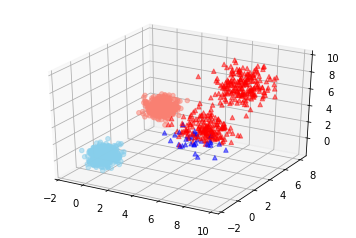

In [10]:
y_source_pred = classification_model.predict(x_source).argmax(1)
y_target_pred = classification_model.predict(x_target).argmax(1)

plot_3d_source_and_target_blobs(x_source, y_source_pred, x_target, y_target_pred)

This figure explains the problem: our simple classifier basically learnt to draw a line (2D plane) between the two training blobs, but the actual target samples are almost all on one side of that line... For this classifier which technically has never even "seen" the target 3D points, all these points are thus belonging to class #1.

We chose the blobs' distributions to illustrate an extreme case of domain divergence, but this problem plagues most machine learning models, and becomes more complex for higher-dimensional domains...

### Introducing Unsupervised Domain Adaptation

Without having access to any target samples at training time, there isn't much we can do to guide our models (though refer to Chapter 7 for some leads). But domain adaptation methods often target scenarios slightly more optimistic: **cases when we have access to some unlabelled target samples**.

Because we do not have any labels for those samples (c.f. scenarios presented in the book), we cannot directly train our model over them in a supervised way. Which is when *unsupervised_ domain adaptation methods become useful. 

But first, let us "gather" our unlabelled target dataset we will be able to use for training:

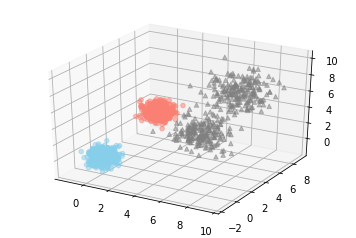

In [11]:
x_target_for_train, y_target_for_train = create_sample_blobs(
    blob_centers=[[6, 3, 3], [7, 6, 7]], 
    blob_stds=[[1, 1, 1], [1, 1, 1]], 
    blob_num_samples= [num_target_samples_per_class] * num_classes)

plot_3d_source_and_target_blobs(x_source, y_source, x_target_for_train, None)

Above is thus all the data we have to train our classifier: nice, labelled samples from the source domain, and more confusing, unlabelled samples from the target domain.

## Implementing and Training DANN

***Domain Adversarial Neural Networks (DANN)*** have been introduced by Hana Ajakan[$^1$](#ref) and Yaroslav Ganin[$^2$](#ref). Though this method is already covered in the book, let us have a brief reminder with the following figure from Chapter 7:

![DANN](./notebook_images/dann.png)

Their method use an implicit information we also have access to: the domain each sample belongs to. They append a second head after the feature-extraction layers of a model, and this head is set to predict the domain of the training samples ($1$ for "source", $0$ for "target"). This secondary-classification head is attached to the feature-extractor through a ***gradient reversal*** layer. While the layers of the secondary head will try to minimize the domain-classification loss during training, the feature-extractor's layers will try to maximize it, as its gradient has been *flipped*. Therefore, during training, the feature extractor will be guided toward learning features which cannot be used to discriminate the domains but which are useful to the network's main task (since the main head is trained at the same time, with its gradient flowing back normally).

***Note:*** Our toy model is much simpler than the VGG one presented in the figure above. We will simply plug the domain-classification head between the hidden layer and output layer.

### Creating a DANN model

To perform gradient reversal, we introduced the function decorator [`@tf.custom_gradient`](https://www.tensorflow.org/api_docs/python/tf/custom_gradient), which makes it possible to manually define how the gradient of the decorated function should be computed (e.g., for backpropagation).

Therefore, gradient reversal can simply be implemented as a function performing identity mapping (i.e., not changing the input tensors when feed-forwarding), but with a custom gradient operation multiplying by $-1$ the upstream gradient: 

In [12]:
@tf.custom_gradient
def reverse_gradient(x, hp_lambda):
    """
    Flips the sign of the incoming gradient during backpropagation.
    :param x:         Input tensor
    :param hp_lambda: Hyper-parameter lambda (c.f. DANN paper), i.e. an updatable 
                      coefficient applied to the reversed gradient
    :return:          Input tensor with reverse gradient (+ function to compute this reversed gradient)
    """
    
    # Feed-forward operation:
    y = tf.identity(x)
    
    # Back-propagation/gradient-computing operation:
    def _flip_gradient(dy):
        # Since the decorated function `reverse_gradient()` actually has 2 inputs 
        # (counting `hp_lambda), we have to return the gradient for each -- but
        # anyway, the derivative w.r.t `hp_lambda` is null:
        return tf.math.negative(dy) * hp_lambda, tf.constant(0.)
    
    return y, _flip_gradient

In order to more easily use this function inside Keras models, we will wrap it as a `Layer`:

In [13]:
class GradientReversal(tf.keras.layers.Layer):
    '''Flip the sign of gradient during training.'''

    def __init__(self, hp_lambda, **kwargs):
        super().__init__(**kwargs)
        self.hp_lambda = hp_lambda

    def call(self, inputs, training=None):
        return reverse_gradient(inputs, self.hp_lambda)

    def get_config(self):
        config = super().get_config()
        config['hp_lambda'] = self.hp_lambda
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

We can now build our secondary head for domain classification, attached to the hidden layer of our mail model, with a gradient reversal layer in between:

In [14]:
hp_lambda = tf.Variable(1.0)
num_domains = 2 # "source" vs. "target"

# We create another simple classification sub-network:
domain_preds_head_name = 'domain_preds'
x = GradientReversal(hp_lambda)(hidden1)
x = Dense(12, activation='linear')(x)
x = Dense(5, activation='linear', name="do5")(x)
x = Activation("elu", name="do6")(x)
x = Dropout(0.5)(x)
domain_preds = Dense(num_domains, activation='softmax', name=domain_preds_head_name)(x)

domain_classification_model = Model(inputs=inputs, outputs=domain_preds)

To train the complete model at once, we create a Keras `Model` instance combining the two heads. We compile this model with a classification loss and related metrics for each head:

In [15]:
combined_model = Model(inputs=inputs, outputs=[class_preds, domain_preds])

combined_model.compile(
    optimizer="adam",
    loss={
        class_preds_head_name:  'sparse_categorical_crossentropy',
        domain_preds_head_name: 'sparse_categorical_crossentropy'},
    loss_weights={
        class_preds_head_name:  1, 
        domain_preds_head_name: 1}, 
    metrics={
        class_preds_head_name:  tf.metrics.SparseCategoricalAccuracy(name='acc'),
        domain_preds_head_name: tf.metrics.SparseCategoricalAccuracy(name='acc')},
    # weight_metrics=True  # not implemented yet. see https://github.com/keras-team/keras/pull/7482
)

combined_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 3)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 5)            20          input_1[0][0]                    
__________________________________________________________________________________________________
gradient_reversal (GradientReve (None, 5)            1           dense[0][0]                      
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 12)           72          gradient_reversal[0][0]          
____________________________________________________________________________________________

### Preparing the Training Data for DANN

We need to adapt our input training pipeline accordingly. We need to create training batches containing:

- source samples and their labels, for the training of the main head;
- target samples and domain labels for the all the elements, for the training of the domain-classifier.

Therefore, we first create `Dataset` pipelines for the training source and target datasets, and we zip them together: 

In [16]:
# We will create batches mostly composed of half source samples and half target samples:
half_batch_size = batch_size // 2

# Source training dataset composed of points and their labels:
source_dataset = tf.data.Dataset.from_tensor_slices((x_source, y_source))
source_dataset = source_dataset.apply(tf.data.experimental.shuffle_and_repeat(
    buffer_size=num_source_samples_per_class * num_classes, count=num_epochs))
source_dataset = source_dataset.batch(half_batch_size)

# Target training dataset composed of points only:
target_dataset = tf.data.Dataset.from_tensor_slices(x_target_for_train)
target_dataset = target_dataset.apply(tf.data.experimental.shuffle_and_repeat(
    buffer_size=num_target_samples_per_class * num_classes, count=-1))
# ^ we repeat the target data indefinitely, counting the epochs w.r.t the source data.
target_dataset = target_dataset.batch(half_batch_size)

# Combined training dataset:
training_dataset = tf.data.Dataset.zip((source_dataset, target_dataset))
print(training_dataset)

<ZipDataset shapes: (((None, 3), (None,)), (None, 3)), types: ((tf.float64, tf.int64), tf.float64)>


We then need to process the batch returned by the current dataset, to have all the images together + their domain labels:

In [17]:
def _prepare_data_for_dann_training(source_data, target_images,
                                    main_head_name='main_preds', domain_head_name='domain_preds'):
    
    source_images, source_labels = source_data
    
    # We check the number of samples for each domains (to cover edge cases, i.e., 
    # for the possibly smaller batch at the end of each epoch):
    num_source = tf.shape(source_images)[0]
    num_target = tf.shape(target_images)[0]
    
    # Full image batch:
    batch_images = tf.concat((source_images, target_images), axis=0)
    
    # Semantic segmentation label maps:
    # By default, the loss will be computed over the full batch, but we do not have GT
    # label maps for the target images. A simplistic solution is as follows:
    # 1) We create dummy GT label maps for the target images:
    target_labels = tf.zeros([num_target, *source_labels.shape[1:]], dtype=source_labels.dtype)
    batch_labels  = tf.concat((source_labels, target_labels), axis=0)
    # 2) We tell TF/Keras **not** to penalize the model for its predictions on the target
    # images/dummy labels, by assigning a weight = 0 to these elements of the batch:
    source_weight_per_sample = tf.tile([1], [num_source])
    target_weight_per_sample = tf.tile([0], [num_target])
    batch_sample_weights = tf.concat((source_weight_per_sample, target_weight_per_sample), 
                                     axis=0)
    
    # Note: this solution is simple but not optimal. Layer and loss operations will be applied
    # to half the batch even though the results won't be used for backpropagation. A better
    # solution to avoid useless computations would be to implement a custom loss aware it
    # should ignore the 2nd half of the batch. Or even better: to edit the model so that
    # only the source images are feed-forwarded to the classification head (e.g., adding a custom
    # layers dropping ~half the batch).
    
    # Domain classification ground-truth labels:
    # if we assign the label "1" to source data and "0" to target data, then we can simply reuse
    # the `batch_sample_weights` tensor:
    domain_labels = batch_sample_weights
    domain_sample_weights = tf.tile([1], [num_source + num_target])
    
    batch_targets = {main_head_name: batch_labels, 
                     domain_head_name: domain_labels}
    batch_sample_weights = {main_head_name: batch_sample_weights, 
                            domain_head_name: domain_sample_weights}

    return batch_images, batch_targets, batch_sample_weights

In [18]:
import functools

prepare_for_dann_fn = functools.partial(_prepare_data_for_dann_training,
                                        main_head_name=class_preds_head_name, 
                                        domain_head_name=domain_preds_head_name)

training_dataset = training_dataset.map(prepare_for_dann_fn, num_parallel_calls=4)
print(training_dataset)

<ParallelMapDataset shapes: ((None, 3), {class_preds: (None,), domain_preds: (None,)}, {class_preds: (None,), domain_preds: (None,)}), types: (tf.float64, {class_preds: tf.int64, domain_preds: tf.int32}, {class_preds: tf.int32, domain_preds: tf.int32})>


Our input pipeline for training is ready! We will create a similar one for our test data, i.e., composed of the labelled target samples we want our method to be able to classify: 

In [19]:
testing_dataset = tf.data.Dataset.from_tensor_slices((x_target, y_target))
testing_dataset = testing_dataset.batch(batch_size)

As we did before, we need to process the batches to provide all the information our model is expecting. The processing is simpler here though, since this dataset is only composed of target data:

In [20]:
def _prepare_data_for_dann_validation(target_images, target_labels,
                                      main_head_name='main_preds', domain_head_name='domain_preds'):
    # The batch contains only validation/test images from the target domain. 
    # This time, we want to evaluate the main loss over these images, so we assign a normal loss
    # weight = 1 to each samples.
    num_samples = tf.shape(target_images)[0]
    
    # We want to evaluate over 
    loss_weights = tf.tile([1], [num_samples])
    
    domain_labels = tf.tile([0], [num_samples])
    
    batch_targets = {main_head_name: target_labels, 
                     domain_head_name: domain_labels}
    batch_sample_weights = {main_head_name: loss_weights, 
                            domain_head_name: loss_weights}

    return target_images, batch_targets, batch_sample_weights

In [21]:
prepare_for_dann_fn = functools.partial(_prepare_data_for_dann_validation,
                                        main_head_name=class_preds_head_name, 
                                        domain_head_name=domain_preds_head_name)

testing_dataset = testing_dataset.map(prepare_for_dann_fn, num_parallel_calls=4)
print(testing_dataset)

<ParallelMapDataset shapes: ((None, 3), {class_preds: (None,), domain_preds: (None,)}, {class_preds: (None,), domain_preds: (None,)}), types: (tf.float64, {class_preds: tf.int64, domain_preds: tf.int32}, {class_preds: tf.int32, domain_preds: tf.int32})>


### Training and Testing DANN

Once the model and dataset ready, training can take place as usual:

In [22]:
import math
train_steps_per_epoch = math.ceil(num_source_samples / half_batch_size)
test_steps_per_epoch  = math.ceil(num_target_samples / batch_size)


# Note: we will display only a subset of the metrics, to keep the logs concise:
metrics_to_print = collections.OrderedDict([
    # ("comb-loss", "loss"), 
    ("c-loss", class_preds_head_name + "_loss"),
    ("d-loss", domain_preds_head_name + "_loss"), 
    ("c-acc", class_preds_head_name + "_acc"),
    ("d-acc", domain_preds_head_name + "_acc"),
    ("target c-acc", "val_" + class_preds_head_name + "_acc"),
    # ("target d-acc", "val_" + domain_preds_head_name + "_acc")
])
callbacks = [
    # Callback to simply log metrics at the end of each epoch (saving space compared to verbose=1/2):
    SimpleLogCallback(metrics_to_print, num_epochs=num_epochs, log_frequency=5)
]

history = combined_model.fit(
    training_dataset, epochs=num_epochs, steps_per_epoch=train_steps_per_epoch,
    validation_data=testing_dataset, validation_steps=test_steps_per_epoch,
    verbose=0, callbacks=callbacks)

Training: start.
Epoch  1/100: c-loss = 0.011; d-loss = 1.518; c-acc = 0.551; d-acc = 0.526; target c-acc = 0.652
Epoch  6/100: c-loss = 0.007; d-loss = 0.604; c-acc = 0.572; d-acc = 0.637; target c-acc = 0.688
Epoch 11/100: c-loss = 0.005; d-loss = 0.436; c-acc = 0.604; d-acc = 0.804; target c-acc = 0.728
Epoch 16/100: c-loss = 0.003; d-loss = 0.348; c-acc = 0.584; d-acc = 0.863; target c-acc = 0.695
Epoch 21/100: c-loss = 0.003; d-loss = 0.419; c-acc = 0.531; d-acc = 0.784; target c-acc = 0.587
Epoch 26/100: c-loss = 0.003; d-loss = 0.538; c-acc = 0.521; d-acc = 0.719; target c-acc = 0.562
Epoch 31/100: c-loss = 0.005; d-loss = 0.747; c-acc = 0.568; d-acc = 0.597; target c-acc = 0.688
Epoch 36/100: c-loss = 0.012; d-loss = 0.722; c-acc = 0.709; d-acc = 0.508; target c-acc = 0.825
Epoch 41/100: c-loss = 0.008; d-loss = 0.579; c-acc = 0.703; d-acc = 0.674; target c-acc = 0.800
Epoch 46/100: c-loss = 0.006; d-loss = 0.547; c-acc = 0.632; d-acc = 0.715; target c-acc = 0.752
Epoch 51/100:

Let us have a look at the logs above. The accuracy of the domain classifier is not better than random guessing, even on the training data (c.f. `d-acc`). This should be good news, meaning our hidden layer may have learnt to rely on features which cannot help distinguishing the domains.

This is confirmed by the incredible improvement regarding the accuracy results for the main classification task over the target test data, reaching above 93% (`target c-acc`)!

***Note:*** Readers may have noticed that, on the other hand, the accuracy results for the main classification task over the training data is weirdly much  lower. The reason is actually that **those training accuracy values are actually incorrect** (`c-acc`). The weights we passed to Keras for the loss computations (so to ignore the dummy labels we generated for the unlabelled target samples) are somehow not taken into account when Keras computed the metrics. This issue is being discussed on its repository: [https://github.com/keras-team/keras/pull/7482](https://github.com/keras-team/keras/pull/7482).

We can verify by ourself, by asking Keras evaluate once again but on the properly labelled source/training and target datasets...

In [23]:
print("Measuring classification accuracy on source/training data:")
res = classification_model.evaluate(x_source, y_source)
print("\nMeasuring classification accuracy on target/test data:")
res = classification_model.evaluate(x_target, y_target)

Measuring classification accuracy on source/training data:
1000/1000 [==============================] - 0s 48us/sample - loss: 0.0133 - acc: 0.9980

Measuring classification accuracy on target/test data:
400/400 [==============================] - 0s 40us/sample - loss: 0.3085 - acc: 0.8275


We can also once again visualize the predicted labels:

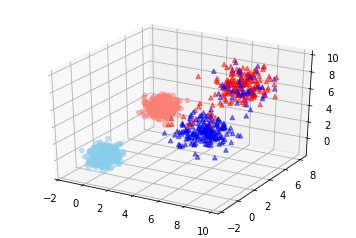

In [24]:
y_source_pred = classification_model.predict(x_source).argmax(1)
y_target_pred = classification_model.predict(x_target).argmax(1)

plot_3d_source_and_target_blobs(x_source, y_source_pred, x_target, y_target_pred)

~94% accuracy on the target/test data is much better! As we can see, it seems like our classifier was forced to consider another "delimitation" separating both the source classes and their target equivalents.

## Conclusion

Even though at no point did we actually provide our model with labels discriminating the samples from the target domain, the _DANN_ scheme taught the model to focus on features robust to the domain variations. Unsupervised domain adaptation methods like this one are important tools in computer vision, as gaps between training and testing data are common. In the next notebook, we will apply the _DANN_ method to our previous problem of segmentic images for self-driving cars, when only synthetic images are available for training.

<a id="ref"></a>
#### References

1. Ajakan, H., Germain, P., Larochelle, H., Laviolette, F. and Marchand, M., 2014. Domain-adversarial neural networks. arXiv preprint arXiv:1412.4446.
2. Ganin, Y., Ustinova, E., Ajakan, H., Germain, P., Larochelle, H., Laviolette, F., Marchand, M. and Lempitsky, V., 2016. Domain-adversarial training of neural networks. The Journal of Machine Learning Research, 17(1), pp.2096-2030.